In [7]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import gurobipy as gp
from gurobipy import GRB

# Fixed correlation investigation



## Setup

### Helper functions

In [8]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [9]:
def construct_sample_dataset(sample_miRNA, sample_mRNA, beta):
    dataset_sample = Dataset()
    gene_pairs, cells = 1, len(sample_mRNA)
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )
    counts_df.iloc[0] = list(zip(sample_miRNA, sample_mRNA))
    dataset_sample.count_dataset = counts_df
    dataset_sample.cells = cells
    dataset_sample.gene_pairs = gene_pairs
    dataset_sample.beta = beta
    return dataset_sample

In [10]:
def moment_correlation_bounds(moment_bounds):
    powers = utils.compute_powers(S=2, d=2)
    i_xy = powers.index([1, 1])
    i_x  = powers.index([1, 0])
    i_y  = powers.index([0, 1])
    i_x2 = powers.index([2, 0])
    i_y2 = powers.index([0, 2])

    # collect moment values
    E_xy = moment_bounds[:, i_xy]
    E_x  = moment_bounds[:, i_x]
    E_y  = moment_bounds[:, i_y]
    E_x2 = moment_bounds[:, i_x2]
    E_y2 = moment_bounds[:, i_y2]

    # compute correlation
    correlation_lb = (E_xy[0] - E_x[1]*E_y[1]) / (np.sqrt(E_x2[1] - E_x[0]**2) * np.sqrt(E_y2[1] - E_y[0]**2))
    correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))

    return correlation_lb, correlation_ub

In [11]:
def direct_correlation_bootstrap(x1_sample, x2_sample, confidence=None, resamples=None):

    # get sample size
    n = len(x1_sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n
    # confidence level: default to 95%
    if confidence is None:
        confidence = 0.95

    # initialize random generator
    rng = np.random.default_rng()

    # separate sample pairs
    x1_sample = list(x1_sample)
    x2_sample = list(x2_sample)

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # compute correlations
    estimates = np.zeros(resamples)
    for i in range(resamples):

        b1 = boot[i, :, 0]
        b2 = boot[i, :, 1]

        E_xy = np.mean(b1 * b2)
        E_x = np.mean(b1)
        E_y = np.mean(b2)
        E_x2 = np.mean(b1**2)
        E_y2 = np.mean(b2**2)

        corr = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))

        #test = scipy.stats.pearsonr(boot[i, :, 0], boot[i, :, 1])
        estimates[i] = corr#test.statistic

    # take quantiles
    alpha = 1 - confidence
    interval = np.quantile(estimates, [(alpha / 2), 1 - (alpha / 2)])

    return interval

### Load data

In [12]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

# remove outlier cell
data_pcRNA = data_pcRNA.drop(labels=['Fibroblasts_P23_S383'], axis=1)
data_miRNA = data_miRNA.drop(labels=['Fibroblasts_P23_S383'], axis=1)
data_FIB = data_FIB.drop(labels=['Fibroblasts_P23_S383'], axis=1)

# estimate capture
beta = estimate_capture(data_FIB)

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Example

pair (MIR100, CDPF1) has correlation 0.6710695745740006

Moment bootstrap correlation bounds (-0.03418529419066962, nan)
Direct bootstrap correlation bounds (-0.06312448173167141, 0.8815931766191091)


C:\Users\willi\AppData\Local\Temp\ipykernel_25220\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


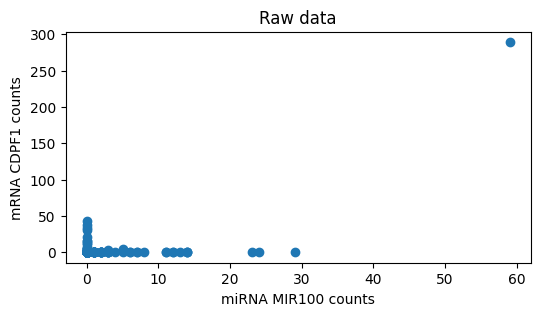

In [16]:
# select pair
miRNA = 'MIR100'
# mRNA = 'CISD1'
mRNA = 'CDPF1'

# settings
confidence = 0.95
d = 6

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA] 
corr = scipy.stats.pearsonr(sample_miRNA, sample_mRNA).statistic
print(f"pair ({miRNA}, {mRNA}) has correlation {corr}\n")

# bootstrap correlation
dataset_sample = construct_sample_dataset(sample_miRNA, sample_mRNA, beta)
dataset_sample.confidence = confidence
dataset_sample.bootstrap(d)
moment_lb, moment_ub = moment_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
direct_lb, direct_ub = direct_correlation_bootstrap(sample_miRNA, sample_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_lb}, {moment_ub})")
print(f"Direct bootstrap correlation bounds ({direct_lb}, {direct_ub})")

# collect observed correlation ranges
observed_correlations = {
    'OB': corr,
    'OB_range_moment': [moment_lb, moment_ub],
    'OB_range_direct': [direct_lb, direct_ub]
}

# display
fig, axs = plt.subplots(figsize=(6, 3))
axs.scatter(sample_miRNA, sample_mRNA)
axs.set_title("Raw data")
axs.set_ylabel(f"mRNA {mRNA} counts")
axs.set_xlabel(f"miRNA {miRNA} counts")
plt.show()

## Save & Load recovery speedup

Rather than repeatedly optimizing the same SDP with only minor changes (fixed correlation value), instead run feasibility test and save the final model *with cuts added*, then load this model and add any constraints (fixed correlation value) before re-optimizing, hopefully then already have cuts needed.

### Fixed correlation example

Compare re-optimizing each time with a new fixed correlation value, to optimizing once and saving cuts in a model that is then re-optimzized with different fixed correlation values

In [ ]:
# function that returns a function that adds a constraint fixing correlation to rho
def constructor(rho):

    def fixed_injection(opt, model, variables):
        
        # get variables
        y = variables['y']

        # get moments
        powers = utils.compute_powers(opt.S, opt.d)
        if opt.S == 4:
            i_xy = powers.index([1, 1, 0, 0])
            i_x  = powers.index([1, 0, 0, 0])
            i_y  = powers.index([0, 1, 0, 0])
            i_x2 = powers.index([2, 0, 0, 0])
            i_y2 = powers.index([0, 2, 0, 0])
        elif opt.S == 2:
            i_xy = powers.index([1, 1])
            i_x  = powers.index([1, 0])
            i_y  = powers.index([0, 1])
            i_x2 = powers.index([2, 0])
            i_y2 = powers.index([0, 2])
        var_x = y[i_x2] - y[i_x]**2
        var_y = y[i_y2] - y[i_y]**2
        cov_xy = y[i_xy] - y[i_x] * y[i_y]

        # dummy zero variable:
        # GUROBI only supports non-linear expressions of the form:
        # variable = f(variables)
        # so 0 = f(variables) can only be done using a dummy zero variable
        z = model.addVar()
        model.addConstr(z == 0, name="Dummy_var")
        model.addConstr(z == rho**2 * var_x * var_y - cov_xy**2, name=f"Correlation_fixed"),
        if rho > 0:
            model.addConstr(cov_xy >= 0, name=f"Correlation_sign")
        else:
            model.addConstr(cov_xy <= 0, name=f"Correlation_sign")

        return model, variables
    
    return fixed_injection

Test feasibility of model, then test feasibility with 2 different fixed correlation values

Run each feasibility test separately, solving the full SDP each time

In [54]:
# feasibility of rho = -0.1
d = 3
opt_own = optimization.TelegraphOptimization(dataset_sample, d)
opt_own.analyse_dataset()
opt_own.result_dict

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


{0: {'status': 'OPTIMAL',
  'time': 2.482999801635742,
  'cuts': 24,
  'correlation': np.float64(-0.04445821188876875)}}

In [55]:
# feasibility of rho = -0.1
opt_own.function_inj = constructor(-0.1)
opt_own.analyse_dataset()
opt_own.result_dict

100%|██████████| 1/1 [01:45<00:00, 105.87s/it]


{0: {'status': 'CUT_LIMIT',
  'time': 105.33899998664856,
  'cuts': 100,
  'correlation': None}}

In [56]:
# feasibility of rho = -0.3
opt_own.function_inj = constructor(-0.3)
opt_own.analyse_dataset()
opt_own.result_dict

100%|██████████| 1/1 [00:16<00:00, 16.13s/it]


{0: {'status': 'OPTIMAL',
  'time': 15.815999984741211,
  'cuts': 30,
  'correlation': np.float64(-0.29999999999999993)}}

This time save the first SDP (with added cuts), then load when testing feasibility of each 2 fixed correlation values

In [57]:
# feasibility of model
d = 3
opt = optimization.TelegraphOptimization(dataset_sample, d, save_model="model_test.lp")
opt.analyse_dataset()
opt.result_dict

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


{0: {'status': 'OPTIMAL',
  'time': 3.371999740600586,
  'cuts': 24,
  'correlation': np.float64(-0.04445821188876875)}}

In [58]:
# feasibility of rho = -0.1
opt.save_model = None
opt.load_model = "model_test.lp"
opt.function_inj = constructor(-0.1)
opt.analyse_dataset()
opt.result_dict

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


{0: {'status': 'OPTIMAL',
  'time': 0.3919999599456787,
  'cuts': 2,
  'correlation': np.float64(-0.1)}}

In [59]:
# feasibility of rho = -0.3
opt.save_model = None
opt.load_model = "model_test.lp"
opt.function_inj = constructor(-0.3)
opt.analyse_dataset()
opt.result_dict

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


{0: {'status': 'OPTIMAL',
  'time': 2.1439998149871826,
  'cuts': 4,
  'correlation': np.float64(-0.29999999999999993)}}

See significant speedup, as many cuts are avoided

### Full recovery interval example

In [62]:
def plot_funnel(recovered_correlations, observed_correlations, rtypes=[], otype="moment", thresh=1, lw=1):

    # type of observed correlation range
    if otype == "moment":
        OB_range = deepcopy(observed_correlations['OB_range_moment'])
    elif otype == "direct":
        OB_range = deepcopy(observed_correlations['OB_range_direct'])
    
    # threshold
    if np.isnan(OB_range[1]) or OB_range[1] > thresh:
        OB_range[1] = thresh

    y = 0

    fig = plt.figure(figsize=(10, 2))
    plt.plot(OB_range, [y, y], color="purple", linewidth=lw, label=f"Observed correlation ({otype})")
    plt.plot([observed_correlations['OB'], observed_correlations['OB']], [y + 0.1, y - 0.1], color="purple", linewidth=2*lw)

    for rtype in rtypes:

        y -= 1

        if rtype == "MF": col = "orange"
        if rtype == "BD": col = "blue"
        if rtype == "TE": col = "green"

        # type of recovered correlation range
        R_range = recovered_correlations[f'{rtype}_range']

        # plt.scatter(R_range, [0 for x in R_range], color="orange", s=10*lw, label=f"Recovered correlation ({rtype})")
        plt.plot([R_range[0], R_range[-1]], [y, y], color=col, linewidth=lw, label=f"Recovered correlation ({rtype})")
        plt.plot([recovered_correlations[rtype], recovered_correlations[rtype]], [y - 0.1, y + 0.1], color=col, linewidth=2*lw)

    plt.title("Feasible Correlations: observed & recovered")
    plt.xlabel("Correlation")
    plt.legend()
    plt.show()

In [60]:
def sample_recovered_correlations(dataset, rho_range, d_MF, d_BD, d_TE):

    # collect
    recovered_correlations = {}

    # Interacting model free
    if d_MF:
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            factorization=False
        )
        opt_MF_int = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, printing=False, silent=True)
        opt_MF_int.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_MF = opt_MF_int.result_dict[0]['correlation']
        recovered_correlation_range_MF = []

        # if feasible
        if opt_MF_int.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                fixed_correlation = rho
                opt_MF_rho = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, silent=True, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_MF_rho.analyse_dataset()
                if opt_MF_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_MF.append(rho)

        recovered_correlations['MF'] = recovered_correlation_MF
        recovered_correlations['MF_range'] = recovered_correlation_range_MF
        
    if d_BD:
        # Interacting birth death
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            factorization=False
        )
        fixed = [(1, 1)]
        opt_BD = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed)
        opt_BD.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_BD = opt_BD.result_dict[0]['correlation']
        recovered_correlation_range_BD = []

        # if feasible
        if opt_BD.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):

                fixed_correlation = rho
                opt_BD_rho = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_BD_rho.analyse_dataset()
                if opt_BD_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_BD.append(rho)

        recovered_correlations['BD'] = recovered_correlation_BD
        recovered_correlations['BD_range'] = recovered_correlation_range_BD

    if d_TE:
        # Interacting telegraph
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            telegraph_moments=True,
            telegraph_moments_ineq=True,
            telegraph_factorization=False
        )
        fixed = [(3, 1)]
        opt_TE = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed)
        opt_TE.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_TE = opt_TE.result_dict[0]['correlation']
        recovered_correlation_range_TE = []

        # if feasible
        if opt_TE.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                fixed_correlation = rho
                opt_TE_rho = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_TE_rho.analyse_dataset()
                if opt_TE_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_TE.append(rho)

        recovered_correlations['TE'] = recovered_correlation_TE
        recovered_correlations['TE_range'] = recovered_correlation_range_TE

    return recovered_correlations

In [61]:
def sample_recovered_correlations_loading(dataset, rho_range, d_MF, d_BD, d_TE):

    # collect
    recovered_correlations = {}

    # Interacting model free
    if d_MF:
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            factorization=False
        )
        opt_MF_int = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, printing=False, silent=True)
        opt_MF_int.save_model = "opt_MF_int.lp" # save model
        opt_MF_int.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_MF = opt_MF_int.result_dict[0]['correlation']
        recovered_correlation_range_MF = []

        # if feasible
        if opt_MF_int.result_dict[0]['status'] == "OPTIMAL":

            # set to load saved model
            opt_MF_int.save_model = None
            opt_MF_int.load_model = "opt_MF_int.lp"

            # update settings
            opt_MF_int.tqdm_disable = True

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):

                # fix correlation
                opt_MF_int.function_inj = constructor(rho)

                # test feasibility & record
                opt_MF_int.analyse_dataset()
                if opt_MF_int.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_MF.append(rho)

        recovered_correlations['MF'] = recovered_correlation_MF
        recovered_correlations['MF_range'] = recovered_correlation_range_MF
        
    if d_BD:
        # Interacting birth death
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            factorization=False
        )
        fixed = [(1, 1)]
        opt_BD = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed)
        opt_BD.save_model = "opt_BD.lp" # save model
        opt_BD.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_BD = opt_BD.result_dict[0]['correlation']
        recovered_correlation_range_BD = []

        # if feasible
        if opt_BD.result_dict[0]['status'] == "OPTIMAL":

            # set to load saved model
            opt_BD.save_model = None
            opt_BD.load_model = "opt_BD.lp"

            # update settings
            opt_BD.tqdm_disable = True

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):

                # fix correlation
                opt_BD.function_inj = constructor(rho)

                # test feasibility & record
                opt_BD.analyse_dataset()
                if opt_BD.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_BD.append(rho)

        recovered_correlations['BD'] = recovered_correlation_BD
        recovered_correlations['BD_range'] = recovered_correlation_range_BD

    if d_TE:
        # Interacting telegraph
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            telegraph_moments=True,
            telegraph_moments_ineq=True,
            telegraph_factorization=False
        )
        fixed = [(3, 1)]
        opt_TE = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed)
        opt_TE.save_model = "opt_TE.lp" # save model
        opt_TE.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_TE = opt_TE.result_dict[0]['correlation']
        recovered_correlation_range_TE = []

        # if feasible
        if opt_TE.result_dict[0]['status'] == "OPTIMAL":

            # set to load saved model
            opt_TE.save_model = None
            opt_TE.load_model = "opt_TE.lp"

            # update settings
            opt_TE.tqdm_disable = True

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                
                # fix correlation
                opt_TE.function_inj = constructor(rho)

                # test feasibility & record
                opt_TE.analyse_dataset()
                if opt_TE.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_TE.append(rho)

        recovered_correlations['TE'] = recovered_correlation_TE
        recovered_correlations['TE_range'] = recovered_correlation_range_TE

    return recovered_correlations

In [64]:
rho_range = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

In [ ]:
recovered_correlations = sample_recovered_correlations(dataset_sample, rho_range=rho_range, d_MF=4, d_BD=3, d_TE=3)

In [65]:
recovered_correlations_loading = sample_recovered_correlations_loading(dataset_sample, rho_range=rho_range, d_MF=4, d_BD=3, d_TE=3)

 67%|██████▋   | 6/9 [00:58<00:34, 11.48s/it]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:606: RuntimeWarning: invalid value encountered in sqrt
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
 78%|███████▊  | 7/9 [01:01<00:19,  9.58s/it]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:606: RuntimeWarning: invalid value encountered in scalar divide
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
100%|██████████| 9/9 [16:56<00:00, 112.95s/it]


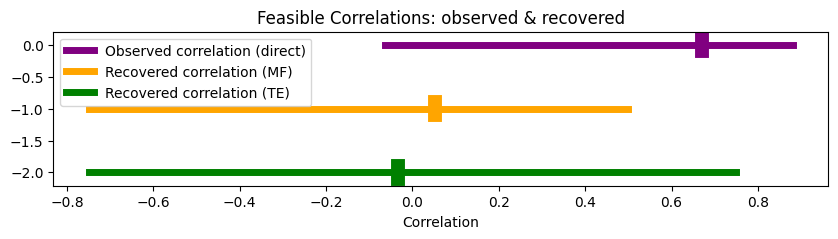

In [68]:
plot_funnel(recovered_correlations_loading, observed_correlations, ["MF", "TE"], "direct", lw=5, thresh=2)